In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import optuna
from sklearn.model_selection import train_test_split
import catboost as cb
from catboost import CatBoostClassifier
from catboost import Pool, cv
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier

import xgboost as xgb

In [2]:
# Loading the excel file
file = r"C:\Users\jvrdo\Desktop\Studije, rad\HRVATSKA BAZA DOJKE 2017 2021 – for study.xlsx"

data = pd.ExcelFile(file)
print(data.sheet_names)

df=data.parse(0)


['2017 2021']


In [3]:
# First look into data
df.head()

,Age,Sample_source,Tumour_type,Tm_size,??,Hist_type,Gradus,ER,PR,HER-2,Ki-67,Immunohist_type,lymph_meta
0,58.0,iglena biopsija,inicijalno metastatski tumor,NaN,NaN,NOS - invazivni karcinom,NaN,95,95,0.0,11,luminal A,NaN
1,76.0,iglena biopsija,inicijalno metastatski tumor,NaN,NaN,lobularni invazivni,NaN,98,98,1.0,43,luminal B,NaN
2,66.0,iglena biopsija,inicijalno metastatski tumor,NaN,NaN,NOS - invazivni karcinom,NaN,100,0,1.0,19,luminal B,NaN
3,63.0,iglena biopsija,inicijalno metastatski tumor,NaN,NaN,NOS - invazivni karcinom,2,100,100,1.0,35,luminal B,NaN
4,70.0,iglena biopsija,inicijalno metastatski tumor,NaN,NaN,lobularni invazivni,1,100,100,0.0,15,luminal A,NaN


In [4]:
# Checking for missing values
df.isna().sum()

Age                  12
Sample_source         0
Tumour_type           0
Tm_size            2644
??                 2724
Hist_type           310
Gradus             2472
ER                    5
PR                    5
HER-2                 7
Ki-67                34
Immunohist_type       0
lymph_meta         3040
dtype: int64

In [5]:
# Checking shape
df.shape

(13580, 13)

In [6]:
# Dropping NaNs
df_2= df.dropna()

In [7]:
# Checking shape after removing NaNs
df_2.shape

(9740, 13)

In [8]:
df_2

,Age,Sample_source,Tumour_type,Tm_size,??,Hist_type,Gradus,ER,PR,HER-2,Ki-67,Immunohist_type,lymph_meta
44,82.0,mastektomija nakon neoadjuvantnog liječenja,inicijalno metatatski tumor,15,difuzno infiltrirajući,lobularni invazivni,2,99,95,2.0,26,luminal B,5
555,52.0,mastektomija nakon neoadjuvantnog liječenja,inicijalno metatatski tumor,1.2,solitaran,NOS - invazivni karcinom,3,0,0,3.0,60,HER2 pozitivni,0
645,62.0,kvadrantektomija,kompletno operiran tumor u vašoj ustanovi,1.6,solitaran,NOS - invazivni karcinom,1,100,70,0.0,7,luminal A,0
646,62.0,kvadrantektomija,kompletno operiran tumor u vašoj ustanovi,2.2,solitaran,NOS - invazivni karcinom,2,95,93,1.0,9,luminal A,0
647,72.0,kvadrantektomija,kompletno operiran tumor u vašoj ustanovi,2.5,solitaran,lobularni invazivni,2,80,60,1.0,12,luminal A,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13567,82.0,mastektomija nakon neoadjuvantnog liječenja,tumor koji se liječio neoadjuvantno,3.2,solitaran,NOS - invazivni karcinom,2,100,100,0.0,9,luminal A,0
13568,60.0,kvadrantektomija,tumor koji se liječio neoadjuvantno,2.7,solitaran,NOS - invazivni karcinom,1,90,30,2.0,60,Luminal B HER2poz,0
13574,60.0,mastektomija nakon neoadjuvantnog liječenja,tumor koji se liječio neoadjuvantno,2,multipli,NOS - invazivni karcinom,2,100,10,2.0,18,Luminal B HER2poz,3
13577,42.0,subkutana mastektomija,tumor koji se liječio neoadjuvantno,1.1,solitaran,NOS - invazivni karcinom,2,98,98,1.0,65,luminal B,1


In [9]:
# Selecting duplicate rows except first
# occurrence based on all columns
duplicate = df_2[df_2.duplicated()]
 
print("Duplicate Rows :")
 
# Print the resultant Dataframe
duplicate.shape

Duplicate Rows :


(31, 13)

In [10]:
# Creating new df without duplicates
df_3= df_2.drop_duplicates()

In [11]:
# Checking shape
df_3.shape

(9709, 13)

## EDA

In [12]:
# Checking value counts for Hist_type
df_3["Hist_type"].value_counts()

NOS - invazivni karcinom              6724
lobularni invazivni                   1107
NOS - invazivni karcinom              1027
mucinozni invazivni                    210
drugi rijetki tipovi                   118
Ca s medularnim karakteristikama        74
 mikropapilarni invazivni karcinom      71
Ca s apokrinom diferencijacijom         61
lobularni invazivni                     58
tubularni invazivni                     47
kribriformni invazivni                  41
metaplastični karcinom                  40
mucinozni invazivni                     31
kribriformni invazivni                  26
mikroinvazivni karcinom                 21
drugi rijetki tipovi                    16
tubularni invazivni                     12
mikropapilarni invazivni karcinom        9
metaplastični karcinom                   7
nOS - invazivni karcinom                 2
ne                                       1
inflamatorni                             1
invazivni mucinozni                      1
miješani NO

Since same Hist_types have multiple entries we will clean up the column.

In [13]:
df_3["Hist_type"].unique()

array(['lobularni invazivni  ', 'NOS - invazivni karcinom ',
       'NOS - invazivni karcinom', 'mucinozni invazivni ',
       'drugi rijetki tipovi ', 'Ca s medularnim karakteristikama',
       ' mikropapilarni invazivni karcinom', 'mikroinvazivni karcinom',
       'Ca s apokrinom diferencijacijom', 'kribriformni invazivni', 'ne',
       'metaplastični karcinom ', 'tubularni invazivni ',
       'kribriformni invazivni ', 'mucinozni invazivni',
       'nOS - invazivni karcinom ', 'drugi rijetki tipovi',
       'inflamatorni', 'tubularni invazivni', 'metaplastični karcinom',
       'lobularni invazivni', 'invazivni mucinozni',
       'mikropapilarni invazivni karcinom', 'miješani NOS/lobularni',
       'Ca tipa prstena pečatnjaka', ' NOS -invazivni karcinom',
       'NOS-invazivni karcinom'], dtype=object)

In [14]:
# Cleaning NOS_invazivni category (same category had multiple names)
df_3['Hist_type'] = df_3['Hist_type'].replace(["NOS - invazivni karcinom "],"NOS_invazivni")

df_3['Hist_type'] = df_3['Hist_type'].replace(["NOS - invazivni karcinom"],"NOS_invazivni")

df_3['Hist_type'] = df_3['Hist_type'].replace([" NOS -invazivni karcinom"],"NOS_invazivni")

df_3['Hist_type'] = df_3['Hist_type'].replace(["NOS-invazivni karcinom"],"NOS_invazivni")

df_3['Hist_type'] = df_3['Hist_type'].replace(["nOS - invazivni karcinom "],"NOS_invazivni")

<ipython-input-14-69d38c0dd8bc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['Hist_type'] = df_3['Hist_type'].replace(["NOS - invazivni karcinom "],"NOS_invazivni")
<ipython-input-14-69d38c0dd8bc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['Hist_type'] = df_3['Hist_type'].replace(["NOS - invazivni karcinom"],"NOS_invazivni")
<ipython-input-14-69d38c0dd8bc>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [15]:
# Cleaning mucinozni invazivni category
df_3['Hist_type'] = df_3['Hist_type'].replace(["invazivni mucinozni"],"mucinozni invazivni")

<ipython-input-15-044d71073f0d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['Hist_type'] = df_3['Hist_type'].replace(["invazivni mucinozni"],"mucinozni invazivni")


In [16]:
df_3['Hist_type'] = df_3['Hist_type'].replace(["mucinozni invazivni "],"mucinozni invazivni")

<ipython-input-16-6272784ec5ca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['Hist_type'] = df_3['Hist_type'].replace(["mucinozni invazivni "],"mucinozni invazivni")


In [17]:
# Cleaning drugi_rijetki_tipovi
df_3['Hist_type'] = df_3['Hist_type'].replace(["drugi rijetki tipovi "],"drugi rijetki tipovi")

# Cleaning tubularni_invazivni
df_3['Hist_type'] = df_3['Hist_type'].replace(["tubularni invazivni "],"tubularni invazivni")

# Cleaning kribiformni invazivni
df_3['Hist_type'] = df_3['Hist_type'].replace(["kribriformni invazivni "],"kribriformni invazivni")

df_3['Hist_type'] = df_3['Hist_type'].replace(["lobularni invazivni  "],"lobularni invazivni")

df_3['Hist_type'] = df_3['Hist_type'].replace(["metaplastični karcinom "],"metaplastični karcinom")

df_3['Hist_type'] = df_3['Hist_type'].replace([" mikropapilarni invazivni karcinom"],"mikropapilarni invazivni karcinom")

<ipython-input-17-39548555ebea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['Hist_type'] = df_3['Hist_type'].replace(["drugi rijetki tipovi "],"drugi rijetki tipovi")
<ipython-input-17-39548555ebea>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['Hist_type'] = df_3['Hist_type'].replace(["tubularni invazivni "],"tubularni invazivni")
<ipython-input-17-39548555ebea>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [18]:
# Changing to "drugi rijetki tipovi"
df_3['Hist_type'] = df_3['Hist_type'].replace(["inflamatorni"],"drugi rijetki tipovi")

df_3['Hist_type'] = df_3['Hist_type'].replace(["miješani NOS/lobularni"],"drugi rijetki tipovi")

df_3['Hist_type'] = df_3['Hist_type'].replace(["metaplastični karcinom"],"drugi rijetki tipovi")

df_3['Hist_type'] = df_3['Hist_type'].replace(["Ca s apokrinom diferencijacijom"],"drugi rijetki tipovi")

df_3['Hist_type'] = df_3['Hist_type'].replace(["mikroinvazivni karcinom"],"drugi rijetki tipovi")

df_3['Hist_type'] = df_3['Hist_type'].replace(["tubularni invazivni"],"drugi rijetki tipovi")

<ipython-input-18-6957627c7a72>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['Hist_type'] = df_3['Hist_type'].replace(["inflamatorni"],"drugi rijetki tipovi")
<ipython-input-18-6957627c7a72>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['Hist_type'] = df_3['Hist_type'].replace(["miješani NOS/lobularni"],"drugi rijetki tipovi")
<ipython-input-18-6957627c7a72>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [19]:
df_3['Hist_type'] = df_3['Hist_type'].replace(["Ca tipa prstena pečatnjaka"],"drugi rijetki tipovi")

df_3['Hist_type'] = df_3['Hist_type'].replace(["ne"],"drugi rijetki tipovi")

<ipython-input-19-32714ce569ad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['Hist_type'] = df_3['Hist_type'].replace(["Ca tipa prstena pečatnjaka"],"drugi rijetki tipovi")
<ipython-input-19-32714ce569ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['Hist_type'] = df_3['Hist_type'].replace(["ne"],"drugi rijetki tipovi")


In [20]:
# Checking types for "Immunohist_type"
df_3["Immunohist_type"].unique()

array(['luminal B ', 'HER2 pozitivni', 'luminal A', 'luminal B',
       'trostruko negativni', 'Luminal B HER2poz', 'luminal B HER2poz',
       'luminal a', 'luminal A '], dtype=object)

In [21]:
# Value count for "Immunohist_type"
df_3["Immunohist_type"].value_counts()

luminal B              4046
luminal A              2799
Luminal B HER2poz       969
trostruko negativni     861
luminal B               670
HER2 pozitivni          361
luminal B HER2poz         1
luminal a                 1
luminal A                 1
Name: Immunohist_type, dtype: int64

In [22]:
df_3['Immunohist_type'] = df_3['Immunohist_type'].replace(["luminal A "],"luminal A")

df_3['Immunohist_type'] = df_3['Immunohist_type'].replace(["luminal a"],"luminal A")

df_3['Immunohist_type'] = df_3['Immunohist_type'].replace(["luminal B "],"luminal B")

df_3['Immunohist_type'] = df_3['Immunohist_type'].replace(["luminal a"],"luminal A")

df_3['Immunohist_type'] = df_3['Immunohist_type'].replace(["luminal B HER2poz"],"Luminal B HER2poz")

<ipython-input-22-04d45348cd75>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['Immunohist_type'] = df_3['Immunohist_type'].replace(["luminal A "],"luminal A")
<ipython-input-22-04d45348cd75>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['Immunohist_type'] = df_3['Immunohist_type'].replace(["luminal a"],"luminal A")
<ipython-input-22-04d45348cd75>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [23]:
# Checking datatypes:
df_3.dtypes

Age                float64
Sample_source       object
Tumour_type         object
Tm_size             object
??                  object
Hist_type           object
Gradus              object
ER                  object
PR                  object
HER-2              float64
Ki-67               object
Immunohist_type     object
lymph_meta          object
dtype: object

In [28]:
# Checking unique values for tumour size
df_3["Tm_size"].unique()

array([15.  ,  1.2 ,  1.6 ,  2.2 ,  2.5 ,  4.5 ,  3.  ,  0.2 ,  1.5 ,
        0.7 ,  1.4 ,  2.  ,  0.9 ,  1.7 ,  1.9 ,  7.  ,  2.8 ,  1.1 ,
        4.2 ,  1.8 ,  2.7 ,  2.3 ,  3.5 ,  5.5 ,  1.3 ,  1.  ,  6.5 ,
        2.6 ,  2.4 ,  4.  ,  0.1 ,  9.  ,  0.6 ,  0.8 ,  5.2 ,  2.1 ,
        6.6 ,  0.3 ,  3.2 ,  3.8 ,  5.  ,  3.4 , 14.  ,  6.  ,  3.7 ,
       12.  ,  0.5 , 10.  ,  0.15,  3.3 ,  0.4 ,  4.7 ,  3.1 ,  4.4 ,
        7.8 ,  5.1 ,  8.5 , 11.  ,  0.25,  4.3 ,  2.9 ,  4.8 ,  0.19,
        7.2 ,  4.9 ,  5.8 ,  0.38,  7.5 ,  8.  ,  9.5 ,  5.7 ,  3.6 ,
       10.5 ,  5.4 ,  6.2 ,  8.4 ,  8.1 ,  3.9 ,  6.3 ,  9.2 , 13.  ,
        6.7 ,  0.13, 19.  , 18.5 ,  6.8 , 20.  , 11.5 , 16.  , 12.5 ,
        7.6 ,  4.6 ,  5.3 ,  0.12,  4.1 ,  5.6 ,  6.4 ,  7.7 ,  0.18,
        0.35,  8.8 , 22.  ,  1.15,  0.  , 18.  ,  0.36,  5.9 ])

In [25]:
df_3['Tm_size'] = df_3['Tm_size'].replace(["1,6 cm"],"1.6")

df_3['Tm_size'] = df_3['Tm_size'].replace(["1,2 cm"],"1.2")

<ipython-input-25-0fd52b4fad63>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['Tm_size'] = df_3['Tm_size'].replace(["1,6 cm"],"1.6")
<ipython-input-25-0fd52b4fad63>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['Tm_size'] = df_3['Tm_size'].replace(["1,2 cm"],"1.2")


In [27]:
df_3["Tm_size"] = df_3["Tm_size"].astype("float")

<ipython-input-27-954c9540907d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3["Tm_size"] = df_3["Tm_size"].astype("float")


In [29]:
# Checking unique values for Gradus
df_3["Gradus"].unique()

array([2, 3, 1, 'NOS - invazivni karcinom ', 'G2'], dtype=object)

In [30]:
df_3['Gradus'] = df_3['Gradus'].replace(['G2'],"2")

<ipython-input-30-05b420191cd1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['Gradus'] = df_3['Gradus'].replace(['G2'],"2")


In [32]:
df_3['Gradus'] = df_3['Gradus'].replace(['NOS - invazivni karcinom '],"2")

<ipython-input-32-bc0e1f665c5f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['Gradus'] = df_3['Gradus'].replace(['NOS - invazivni karcinom '],"2")


In [33]:
df_3["Gradus"] = df_3["Gradus"].astype("int")

<ipython-input-33-f93ff34d4917>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3["Gradus"] = df_3["Gradus"].astype("int")


In [34]:
# Checking unique values for lymph_meta
df_3["lymph_meta"].unique()

array([5, 0, 1, 13, 4, 2, 9, 12, 17, 3, 7, 22, 8, 6, 20, 15, 11, 10, 19,
       14, 16, 18, 21, 25, 27, 23, 28, 29, 34, 24, 'T1bN0', 26, 30],
      dtype=object)

In [35]:
df_3[df_3["lymph_meta"]=="T1bN0"]

,Age,Sample_source,Tumour_type,Tm_size,??,Hist_type,Gradus,ER,PR,HER-2,Ki-67,Immunohist_type,lymph_meta
7435,59.0,kvadrantektomija,kompletno operiran tumor u vašoj ustanovi,1.0,solitaran,lobularni invazivni,2,100,90,1.0,5,luminal A,T1bN0


In [36]:
df_3['lymph_meta'] = df_3['lymph_meta'].replace(['T1bN0'],"0")

<ipython-input-36-1096e5fe1237>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['lymph_meta'] = df_3['lymph_meta'].replace(['T1bN0'],"0")


In [37]:
df_3["lymph_meta"] = df_3["lymph_meta"].astype("int")

<ipython-input-37-33ec09edbc45>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3["lymph_meta"] = df_3["lymph_meta"].astype("int")


In [38]:
df_3["lymph_meta"].value_counts()

0     6414
1     1413
2      594
3      295
4      203
5      169
6      128
7      100
8       71
10      51
9       48
11      39
13      38
12      29
14      25
15      21
16      17
20      11
18      10
19       7
17       6
22       3
26       3
21       3
27       2
23       2
25       2
28       1
29       1
34       1
24       1
30       1
Name: lymph_meta, dtype: int64

In [39]:
# Changing other numerical types to float 
df_3["ER"] = df_3["ER"].astype("float")

df_3["PR"] = df_3["PR"].astype("float")

df_3["HER-2"] = df_3["HER-2"].astype("float")

df_3["Ki-67"] = df_3["Ki-67"].astype("float")



<ipython-input-39-4f4de76c3259>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3["ER"] = df_3["ER"].astype("float")
<ipython-input-39-4f4de76c3259>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3["PR"] = df_3["PR"].astype("float")
<ipython-input-39-4f4de76c3259>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [41]:
df_3.dtypes

Age                float64
Sample_source       object
Tumour_type         object
Tm_size            float64
??                  object
Hist_type           object
Gradus               int32
ER                 float64
PR                 float64
HER-2              float64
Ki-67              float64
Immunohist_type     object
lymph_meta           int32
dtype: object

Text(0.5, 1.0, 'Correlation Heatmap')

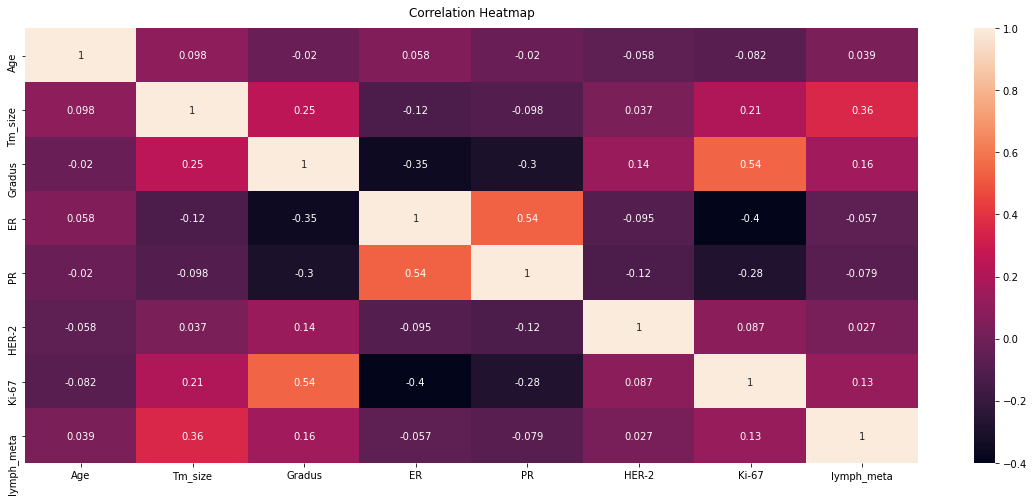

In [42]:
# Increasing the heatmap size
plt.figure(figsize=(20, 8))

# Plotting correlations
heatmap= sns.heatmap(df_3.corr(),annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [49]:
# Checking values by sample source
df_3["Sample_source"].value_counts()

kvadrantektomija                                4978
klasična mastektomija                           2978
mastektomija nakon neoadjuvantnog liječenja      594
subkutana mastektomija                           561
tumorektomija                                    492
mastektomija nakon neoadjuvantnog liječenja       94
radikalna mastektomija                             4
parafinski blok                                    3
Tumorektomija                                      1
otvorena biopsija tumora                           1
jednostavna mastektomija                           1
mastektomija                                       1
Mastektomija nakon neoadjuvantnog liječenja        1
Name: Sample_source, dtype: int64

In [50]:
# Checking values by tumour type
df_3["Tumour_type"].value_counts()

kompletno operiran tumor u vašoj ustanovi    8383
tumor koji se liječio neoadjuvantno          1323
inicijalno metatatski tumor                     2
tumor koji se liječio neoadjuvantno             1
Name: Tumour_type, dtype: int64

In [53]:
df_3["Tumour_type"].unique()

array(['inicijalno metatatski tumor',
       'kompletno operiran tumor u vašoj ustanovi',
       'tumor koji se liječio neoadjuvantno'], dtype=object)

In [43]:
df_3['Tumour_type'] = df_3['Tumour_type'].replace(["tumor koji se liječio neoadjuvantno "],"tumor koji se liječio neoadjuvantno")

<ipython-input-43-b2a17d8666b4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['Tumour_type'] = df_3['Tumour_type'].replace(["tumor koji se liječio neoadjuvantno "],"tumor koji se liječio neoadjuvantno")


In [44]:
# Exctracting all rows which contain a substring "Pneumonia"
result = df_3["Tumour_type"].str.contains(pat = 'neoadjuvantno')

result

44       False
555      False
645      False
646      False
647      False
         ...  
13567     True
13568     True
13574     True
13577     True
13578     True
Name: Tumour_type, Length: 9709, dtype: bool

In [45]:
# Creating a dictionary and mapping the values to create a new column in our dataframe
temp = {True:1, False:0}
df_3['Neoadj'] = result.map(temp)

<ipython-input-45-86bb35b43193>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['Neoadj'] = result.map(temp)


In [46]:
# Checking values by tumour type
df_3["Immunohist_type"].value_counts()

luminal B              4716
luminal A              2801
Luminal B HER2poz       970
trostruko negativni     861
HER2 pozitivni          361
Name: Immunohist_type, dtype: int64

In [52]:
df_3.drop(["Sample_source","Tumour_type"], axis=1, inplace=True)

<ipython-input-52-e1427351ab3f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3.drop(["Sample_source","Tumour_type"], axis=1, inplace=True)


In [53]:
df_3

,Age,Tm_size,??,Hist_type,Gradus,ER,PR,HER-2,Ki-67,Immunohist_type,lymph_meta,Neoadj,Target
44,82.0,15.0,difuzno infiltrirajući,lobularni invazivni,2,99.0,95.0,2.0,26.0,luminal B,5,0,1
555,52.0,1.2,solitaran,NOS_invazivni,3,0.0,0.0,3.0,60.0,HER2 pozitivni,0,0,0
645,62.0,1.6,solitaran,NOS_invazivni,1,100.0,70.0,0.0,7.0,luminal A,0,0,0
646,62.0,2.2,solitaran,NOS_invazivni,2,95.0,93.0,1.0,9.0,luminal A,0,0,0
647,72.0,2.5,solitaran,lobularni invazivni,2,80.0,60.0,1.0,12.0,luminal A,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13567,82.0,3.2,solitaran,NOS_invazivni,2,100.0,100.0,0.0,9.0,luminal A,0,1,0
13568,60.0,2.7,solitaran,NOS_invazivni,1,90.0,30.0,2.0,60.0,Luminal B HER2poz,0,1,0
13574,60.0,2.0,multipli,NOS_invazivni,2,100.0,10.0,2.0,18.0,Luminal B HER2poz,3,1,1
13577,42.0,1.1,solitaran,NOS_invazivni,2,98.0,98.0,1.0,65.0,luminal B,1,1,1


C:\Users\jvrdo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Tm_size', ylabel='Density'>

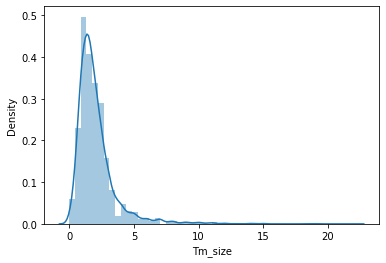

In [49]:
sns.distplot(df_3["Tm_size"])

In [47]:
# saving the dataframe
df_3.to_csv('ly_pred_clean_2')

In [54]:
df_dummies = pd.get_dummies(df_3, columns=['??',"Hist_type", "Immunohist_type"], drop_first=True)

df_dummies.dropna(inplace=True)

In [50]:
# Creating a function that returns 1 if "broj meta lc" is >0:
def target(df):
    if df["lymph_meta"] > 0:
        return 1
    else:
        return 0
    
    
# Applying function to our dataframe
df_3["Target"] = df_3.apply(lambda df_3: target(df_3), axis=1)

<ipython-input-50-809a28196d4a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3["Target"] = df_3.apply(lambda df_3: target(df_3), axis=1)


In [55]:
# Drop the old column
df_dummies.drop("lymph_meta", axis=1, inplace=True)

In [56]:
df_dummies

,Age,Tm_size,Gradus,ER,PR,HER-2,Ki-67,Neoadj,Target,??_bifokalan,...,Hist_type_NOS_invazivni,Hist_type_drugi rijetki tipovi,Hist_type_kribriformni invazivni,Hist_type_lobularni invazivni,Hist_type_mikropapilarni invazivni karcinom,Hist_type_mucinozni invazivni,Immunohist_type_Luminal B HER2poz,Immunohist_type_luminal A,Immunohist_type_luminal B,Immunohist_type_trostruko negativni
44,82.0,15.0,2,99.0,95.0,2.0,26.0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
555,52.0,1.2,3,0.0,0.0,3.0,60.0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
645,62.0,1.6,1,100.0,70.0,0.0,7.0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
646,62.0,2.2,2,95.0,93.0,1.0,9.0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
647,72.0,2.5,2,80.0,60.0,1.0,12.0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13567,82.0,3.2,2,100.0,100.0,0.0,9.0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
13568,60.0,2.7,1,90.0,30.0,2.0,60.0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
13574,60.0,2.0,2,100.0,10.0,2.0,18.0,1,1,0,...,1,0,0,0,0,0,1,0,0,0
13577,42.0,1.1,2,98.0,98.0,1.0,65.0,1,1,0,...,1,0,0,0,0,0,0,0,1,0


In [57]:
X= df_dummies.drop(["Target"], axis=1)
y= df_dummies["Target"]

In [102]:
# New train test split after encoding categorical variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=68, stratify=y)

In [103]:
clf = RandomForestClassifier( random_state=68)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=68)

In [104]:
y_pred = clf.predict_proba(X_test)

y_pred= y_pred[:,1].reshape(-1,1)



In [105]:
roc_auc_score(y_test, y_pred)

0.7140783813170708

## Optimizing with StratifiedKFold and HalvingGridSearchCV

In [106]:
# parameter grid
pgrid = {    
    'max_depth' : [50,200,300],    
    'min_samples_split' : [3, 10,20,30],
    'min_samples_leaf' : [1,2,5,7,20],
    'class_weight': ['balanced','balanced_subsample']
}

# specifying the cv
cv_skf = StratifiedKFold(n_splits=5, random_state=68, shuffle=True)

# specifying the model 
rfgs = BalancedRandomForestClassifier(n_jobs=-1)



# specify the grid search cv
cv = HalvingGridSearchCV(estimator=rfgs,param_grid=pgrid,cv=cv_skf,n_jobs=-1,verbose=10, scoring='roc_auc',random_state=68)

cc= cv.fit(X_train,y_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 107
max_resources_: 8738
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 120
n_resources: 107
Fitting 5 folds for each of 120 candidates, totalling 600 fits
----------
iter: 1
n_candidates: 40
n_resources: 321
Fitting 5 folds for each of 40 candidates, totalling 200 fits
----------
iter: 2
n_candidates: 14
n_resources: 963
Fitting 5 folds for each of 14 candidates, totalling 70 fits
----------
iter: 3
n_candidates: 5
n_resources: 2889
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 4
n_candidates: 2
n_resources: 8667
Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [107]:
cc.best_params_

{'class_weight': 'balanced_subsample',
 'max_depth': 300,
 'min_samples_leaf': 2,
 'min_samples_split': 30}

In [108]:
y_pred= cc.predict_proba(X_test)
y_pred= y_pred[:,1].reshape(-1,1)



In [109]:
test_score= roc_auc_score(y_test, y_pred)

test_score

0.7420696827873114

In [116]:
# Running the optimized randomforrest
clf_optimized = RandomForestClassifier(max_depth=300, min_samples_leaf=2, n_estimators=150, min_samples_split=30, random_state=68,
                                      class_weight="balanced_subsample")
clf_optimized.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=300,
                       min_samples_leaf=2, min_samples_split=30,
                       n_estimators=150, random_state=68)

In [117]:
y_pred_o = clf_optimized.predict_proba(X_test)

y_pred_o= y_pred_o[:,1].reshape(-1,1)


In [118]:
roc_auc_score(y_test, y_pred_o)

0.7453930884508108